In [117]:
import pandas as pd
gsc_data = pd.read_csv('GSC+.csv', converters={'HPO_codes': eval, 'starts': eval, 'ends': eval, 'HPO_symptoms': eval})

In [141]:
gsc_data.shape

(228, 6)

In [142]:
gsc_data.iloc[0]['text']

'A syndrome of brachydactyly (absence of some middle or distal phalanges), aplastic or hypoplastic nails, symphalangism (ankylois of proximal interphalangeal joints), synostosis of some carpal and tarsal bones, craniosynostosis, and dysplastic hip joints is reported in five members of an Italian family. It may represent a previously undescribed autosomal dominant trait.'

In [143]:
gsc_data.iloc[0]['HPO_symptoms']

['brachydactyly',
 'absence of some middle or distal phalanges',
 'aplastic or hypoplastic nails',
 'hypoplastic nails',
 'symphalangism',
 'ankylois of proximal interphalangeal joints',
 'synostosis of some carpal and tarsal bones',
 'craniosynostosis',
 'dysplastic hip joints',
 'autosomal dominant trait',
 'autosomal dominant',
 'dominant',
 'dominant trait']

In [118]:
gsc_data.head()

,file,text,HPO_symptoms,HPO_codes,starts,ends
0,1003450,A syndrome of brachydactyly (absence of some m...,"[brachydactyly, absence of some middle or dist...","[0001156, 0009881, 0001798, 0001792, 0100264, ...","[14, 29, 74, 86, 105, 120, 166, 210, 232, 346,...","[27, 71, 103, 103, 118, 163, 208, 226, 253, 37..."
1,10051003,Townes-Brocks syndrome (TBS) is an autosomal d...,"[autosomal dominant disorder, autosomal domina...","[0000006, 0000006, 0000006, 0003828, 0003813, ...","[35, 35, 45, 95, 95, 139, 148, 163, 177, 186, ...","[62, 53, 53, 114, 103, 161, 161, 175, 197, 197..."
2,10066029,Nevoid basal cell carcinoma syndrome (NBCCS) i...,"[basal cell carcinoma, autosomal dominant, aut...","[0002671, 0000006, 0000006, 0000006, 0000006, ...","[7, 89, 89, 99, 99, 143, 143, 208, 238, 250, 2...","[27, 107, 113, 113, 107, 164, 151, 229, 261, 2..."
3,10196695,Angelman syndrome (AS) is a neurodevelopmental...,"[neurodevelopmental disorder, contiguous gene ...","[0000707, 0001466]","[28, 839]","[55, 863]"
4,10417280,Prader-Willi syndrome (PWS) and Angelman syndr...,"[neurobehavioral disorders, de novo]","[0000708, 0003745]","[68, 223]","[93, 230]"


In [119]:
# Create a similar columns for NCR output and MTA output 

In [47]:
import requests
def call_ncr(text):
    endpoint = 'https://ncr.ccm.sickkids.ca/curr/annotate/'
    r = requests.get(endpoint, params={'text': text})
    if r.status_code == 200:
        output = r.json()
        starts = [entry['start'] for entry in output['matches']]
        ends = [entry['end'] for entry in output['matches']]
        names = [entry['names'][0] for entry in output['matches']] # TODO should we stick with 0?
        hp_id = [entry['hp_id'][3:] for entry in output['matches']]
        scores = [entry['score'] for entry in output['matches']]
        return {
            'NCR_start': starts,
            'NCR_end': ends,
            'NCR_symptoms': names,
            'NCR_HPO_codes': hp_id,
            'NCR_confidence_score': scores,
        }
    else:
        print(r.text)
        return {}

In [48]:
sample_text = gsc_data.iloc[0]['text']

In [330]:
#Function to call Biolink Entity Annotator
def call_biolink(text):
    endpoint = 'https://api.monarchinitiative.org/api/nlp/annotate/entities/'
    r = requests.get(endpoint, params={'content': text})
    if r.status_code == 200:
        
        output = r.json()
        starts = []
        ends = []
        names = []
        hp_id = []
        
        for entry in output['spans']:
            
            if ('HP' not in entry['token'][0]['id']):
                continue; #Skip none HP entries
                
            if len(entry['token'][0]['terms'])==0:
                continue; #Skip if entry has no terms
                
            starts.append(entry['start'])
            ends.append(entry['end'])
            names.append(entry['token'][0]['terms'][0]) 
            hp_id.append(entry['token'][0]['id'][3:])
            
        return {
            'Biolink_start': starts,
            'Biolink_end': ends,
            'Biolink_symptoms': names,
            'Biolink_HPO_codes': hp_id,
        }
    else:
        print(r.text)
        return {}

In [52]:
import time
ncr_rows = []
for ind, text in enumerate(gsc_data['text']):
    ncr_output = call_ncr(text)
    ncr_rows.append(ncr_output)
    if (ind + 1) % 10 == 0:
        print('Fetched {} rows'.format(ind + 1))
    time.sleep(1)
ncr_df = pd.DataFrame(ncr_rows)

Fetched 10 rows
Fetched 20 rows
Fetched 30 rows
Fetched 40 rows
Fetched 50 rows
Fetched 60 rows
Fetched 70 rows
Fetched 80 rows
Fetched 90 rows
Fetched 100 rows
Fetched 110 rows
Fetched 120 rows
Fetched 130 rows
Fetched 140 rows
Fetched 150 rows
Fetched 160 rows
Fetched 170 rows
Fetched 180 rows
Fetched 190 rows
Fetched 200 rows
Fetched 210 rows
Fetched 220 rows


In [54]:
ncr_df.head(10)

,NCR_start,NCR_end,NCR_symptoms,NCR_HPO_codes,NCR_confidence_score
0,"[0, 210, 74, 232, 166]","[27, 226, 103, 246, 208]","[Type A brachydactyly, Craniosynostosis, Aplas...","[0009370, 0001363, 0008386, 0001385, 0100266]","[0.854373, 0.9803171, 0.97019005, 0.9812449, 0..."
1,"[139, 163, 177, 202, 224, 246, 314, 344]","[161, 175, 197, 222, 240, 265, 333, 362]","[Abnormality of the outer ear, Hearing impairm...","[0000356, 0000365, 0100258, 0001199, 0002023, ...","[0.9629303, 0.9879309, 0.9797104, 0.9904183, 0..."
2,"[7, 704, 208, 238, 289, 330, 303, 447, 550]","[27, 716, 229, 273, 301, 357, 325, 476, 562]","[Basal cell carcinoma, Abnormality of skin pig...","[0002671, 0001000, 0002671, 0010603, 0010612, ...","[0.99626815, 0.8976064, 0.9970914, 0.98232365,..."
3,"[83, 205]","[104, 213]","[Prenatal maternal abnormality, Prenatal mater...","[0002686, 0002686]","[0.9450763, 0.93650734]"
4,[180],[188],[Prenatal maternal abnormality],[0002686],[0.93650734]
5,"[439, 376, 421, 504, 546, 77, 59, 138, 164, 298]","[468, 389, 434, 506, 559, 106, 72, 147, 183, 317]","[Abnormality of the seventh cranial nerve, Cho...","[0010827, 0009797, 0009797, 0500001, 0009797, ...","[0.95614415, 0.9940772, 0.9940772, 0.9919378, ..."
6,"[57, 84, 108, 124, 136, 155, 169, 268, 300, 27...","[82, 106, 119, 134, 153, 161, 186, 275, 323, 2...","[Intellectual disability, severe, Postnatal mi...","[0010864, 0005484, 0000154, 0000303, 0001344, ...","[0.99669075, 0.99157083, 0.9878103, 0.9828453,..."
7,"[0, 796, 119, 135, 191, 205, 928, 968, 1092, 1...","[17, 802, 130, 146, 201, 215, 938, 974, 1102, ...","[Neurofibromas, Neoplasm, Schwannoma, Meningio...","[0001067, 0002664, 0100008, 0002858, 0002858, ...","[0.995176, 0.98074406, 0.994758, 0.8937297, 0...."
8,"[0, 277, 265, 583, 625, 208, 219, 233, 249]","[19, 291, 272, 599, 639, 217, 231, 247, 259]","[Popliteal pterygium, Abnormality of the nail,...","[0009756, 0001597, 0000078, 0000202, 0000196, ...","[0.98863715, 0.9172121, 0.9366641, 0.9634072, ..."
9,"[136, 154, 178, 209, 1084, 312, 433, 486, 746,...","[152, 173, 191, 217, 1090, 317, 447, 505, 759,...","[Anal atresia, Triphalangeal thumb, Abnormalit...","[0002023, 0001199, 0000356, 0000365, 0001167, ...","[0.9931391, 0.9913281, 0.92845136, 0.98989284,..."


In [55]:
ncr_df.to_csv('ncr_output.csv')

In [56]:
# we have multisets here, how to do the overlap exactly?
# this could be sorted by positions

In [121]:
gsc_data.dtypes

file             int64
text            object
HPO_symptoms    object
HPO_codes       object
starts          object
ends            object
dtype: object

In [125]:
def jaccard_score(a, b):
    return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))

In [131]:
from sklearn import metrics

def jaccard_evaluation():
    jaccard_scores = []
    for i, row in ncr_df.iterrows():
        gsc_row = gsc_data.iloc[i]
        gsc_codes = gsc_row['HPO_codes']
        ncr_codes = row['NCR_HPO_codes']
        score = jaccard_score(gsc_codes, ncr_codes)
        jaccard_scores.append(score)
    return jaccard_scores

In [132]:
jaccard_scores = jaccard_evaluation()

In [133]:
ncr_df['jaccard_overlap'] = jaccard_scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023254C5F8C8>]],
      dtype=object)

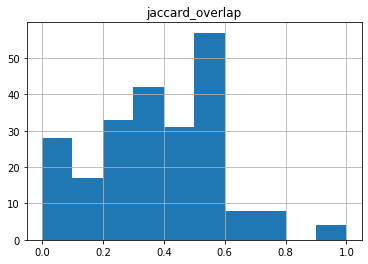

In [136]:
ncr_df.hist('jaccard_overlap')

In [144]:
ncr_df['jaccard_overlap'].mean()

0.36920936284125916

In [146]:
gsc_data.iloc[0]['HPO_codes']

['0001156',
 '0009881',
 '0001798',
 '0001792',
 '0100264',
 '0008090',
 '0009702',
 '0001363',
 '0001385',
 '0000006',
 '0000006',
 '0000006',
 '0000006']

In [147]:
ncr_df.iloc[0]['NCR_HPO_codes']

['0009370', '0001363', '0008386', '0001385', '0100266']

In [139]:
ncr_df

,NCR_start,NCR_end,NCR_symptoms,NCR_HPO_codes,NCR_confidence_score,jaccard_overlap
0,"[0, 210, 74, 232, 166]","[27, 226, 103, 246, 208]","[Type A brachydactyly, Craniosynostosis, Aplas...","[0009370, 0001363, 0008386, 0001385, 0100266]","[0.854373, 0.9803171, 0.97019005, 0.9812449, 0...",0.153846
1,"[139, 163, 177, 202, 224, 246, 314, 344]","[161, 175, 197, 222, 240, 265, 333, 362]","[Abnormality of the outer ear, Hearing impairm...","[0000356, 0000365, 0100258, 0001199, 0002023, ...","[0.9629303, 0.9879309, 0.9797104, 0.9904183, 0...",0.357143
2,"[7, 704, 208, 238, 289, 330, 303, 447, 550]","[27, 716, 229, 273, 301, 357, 325, 476, 562]","[Basal cell carcinoma, Abnormality of skin pig...","[0002671, 0001000, 0002671, 0010603, 0010612, ...","[0.99626815, 0.8976064, 0.9970914, 0.98232365,...",0.500000
3,"[83, 205]","[104, 213]","[Prenatal maternal abnormality, Prenatal mater...","[0002686, 0002686]","[0.9450763, 0.93650734]",0.000000
4,[180],[188],[Prenatal maternal abnormality],[0002686],[0.93650734],0.000000
...,...,...,...,...,...,...
223,"[46, 670, 699, 686]","[56, 681, 709, 693]","[Overgrowth, Polyphagia, Overgrowth, Obesity]","[0001548, 0002591, 0001548, 0001513]","[0.99701005, 0.9962139, 0.99701005, 0.98880225]",1.000000
224,"[26, 120, 548, 226, 971, 810, 872, 469, 311, 394]","[59, 137, 554, 233, 1003, 816, 879, 476, 344, ...","[Unilateral vestibular Schwannoma, Neurofibrom...","[0009590, 0001067, 0002664, 0002664, 0009590, ...","[0.8733457, 0.995176, 0.98074406, 0.96545285, ...",0.181818
225,"[97, 705, 734, 158, 184, 286, 239, 953, 866, 809]","[117, 726, 750, 179, 200, 295, 245, 960, 886, ...","[Basal cell carcinoma, Basal cell carcinoma, M...","[0002671, 0002671, 0002885, 0002671, 0002885, ...","[0.99626815, 0.9970914, 0.8956474, 0.9970914, ...",0.600000
226,[],[],[],[],[],0.000000


Slides
* answer the question which algorithm is better on average
* how often one is better than the other and vice versa
* when the one is better than the other? (try to find some categories)
* how many HPO we have here
* report metrics for both algorithms
* briefly describe the work done
* briefly describe the data

Tasks for now
* pull the CliPhen and Text Analytics data
* double check we're doing it right and aggregate the results
* what to do with the negated????
* filter out non-symptoms (from where)
* calculate jaccard over that
* run the BioLink similiarity
* compare and visualize the results

### Text Analytics for Health

In [152]:
ta_health_df = pd.read_csv('TAforHealth_results.csv', 
                           converters={'offset_list': eval, 'length_list': eval,
                                       'text_list': eval, 'score_list': eval,
                                      'isNegated_list': eval, 'HPO_codes': eval})

In [153]:
ta_health_df.head()

,file,offset_list,length_list,text_list,score_list,isNegated_list,HPO_codes
0,1003450,"[14, 86, 105, 210]","[13, 17, 13, 16]","[brachydactyly, hypoplastic nails, symphalangi...","[0.89, 0.67, 0.94, 0.99]","[False, True, True, True]","[0001156, 0001792, 0001159, 0001363]"
1,10051003,"[177, 202, 224, 246, 344]","[20, 20, 16, 19, 18]","[preaxial polydactyly, triphalangeal thumbs, i...","[0.89, 0.84, 0.76, 0.94, 0.97]","[False, False, False, False, False]","[0100258, 0001199, 0002023, 0012210, 0001249]"
2,10066029,"[208, 231, 238, 289, 303, 330, 447, 534, 550, ...","[21, 4, 35, 12, 22, 27, 29, 4, 12, 4]","[basal cell carcinomas, BCCs, odontogenic kera...","[0.99, 0.99, 0.9, 0.62, 1.0, 0.65, 0.68, 0.99,...","[False, False, False, False, False, False, Fal...","[0002671, 0002671, 0010603, 0010612, 0000924, ..."
3,10196695,"[277, 297, 839]","[18, 3, 24]","[uniparental disomy, UPD, contiguous gene synd...","[0.99, 0.99, 0.99]","[False, False, False]","[0032382, 0032382, 0001466]"
4,10417280,[],[],[],[],[],[]


In [154]:
ta_health_df.shape

(228, 7)

In [156]:
ta_health_jaccard_scores = []
for i, row in ta_health_df.iterrows():
    gsc_row = gsc_data.iloc[i]
    gsc_codes = gsc_row['HPO_codes']
    ta_health_codes = row['HPO_codes']
    score = jaccard_score(gsc_codes, ta_health_codes)
    ta_health_jaccard_scores.append(score)

In [166]:
ta_health_jaccard_scores[:10]

[0.2727272727272727,
 0.21428571428571427,
 0.5454545454545454,
 0.3333333333333333,
 0.0,
 0.14285714285714285,
 0.26666666666666666,
 0.4,
 0.23076923076923078,
 0.30434782608695654]

In [158]:
ta_health_df['jaccard_score'] = ta_health_jaccard_scores

In [159]:
ta_health_df.head()

,file,offset_list,length_list,text_list,score_list,isNegated_list,HPO_codes,jaccard_score
0,1003450,"[14, 86, 105, 210]","[13, 17, 13, 16]","[brachydactyly, hypoplastic nails, symphalangi...","[0.89, 0.67, 0.94, 0.99]","[False, True, True, True]","[0001156, 0001792, 0001159, 0001363]",0.272727
1,10051003,"[177, 202, 224, 246, 344]","[20, 20, 16, 19, 18]","[preaxial polydactyly, triphalangeal thumbs, i...","[0.89, 0.84, 0.76, 0.94, 0.97]","[False, False, False, False, False]","[0100258, 0001199, 0002023, 0012210, 0001249]",0.214286
2,10066029,"[208, 231, 238, 289, 303, 330, 447, 534, 550, ...","[21, 4, 35, 12, 22, 27, 29, 4, 12, 4]","[basal cell carcinomas, BCCs, odontogenic kera...","[0.99, 0.99, 0.9, 0.62, 1.0, 0.65, 0.68, 0.99,...","[False, False, False, False, False, False, Fal...","[0002671, 0002671, 0010603, 0010612, 0000924, ...",0.545455
3,10196695,"[277, 297, 839]","[18, 3, 24]","[uniparental disomy, UPD, contiguous gene synd...","[0.99, 0.99, 0.99]","[False, False, False]","[0032382, 0032382, 0001466]",0.333333
4,10417280,[],[],[],[],[],[],0.000000


In [160]:
ncr_df.head()

,NCR_start,NCR_end,NCR_symptoms,NCR_HPO_codes,NCR_confidence_score,jaccard_overlap
0,"[0, 210, 74, 232, 166]","[27, 226, 103, 246, 208]","[Type A brachydactyly, Craniosynostosis, Aplas...","[0009370, 0001363, 0008386, 0001385, 0100266]","[0.854373, 0.9803171, 0.97019005, 0.9812449, 0...",0.153846
1,"[139, 163, 177, 202, 224, 246, 314, 344]","[161, 175, 197, 222, 240, 265, 333, 362]","[Abnormality of the outer ear, Hearing impairm...","[0000356, 0000365, 0100258, 0001199, 0002023, ...","[0.9629303, 0.9879309, 0.9797104, 0.9904183, 0...",0.357143
2,"[7, 704, 208, 238, 289, 330, 303, 447, 550]","[27, 716, 229, 273, 301, 357, 325, 476, 562]","[Basal cell carcinoma, Abnormality of skin pig...","[0002671, 0001000, 0002671, 0010603, 0010612, ...","[0.99626815, 0.8976064, 0.9970914, 0.98232365,...",0.500000
3,"[83, 205]","[104, 213]","[Prenatal maternal abnormality, Prenatal mater...","[0002686, 0002686]","[0.9450763, 0.93650734]",0.000000
4,[180],[188],[Prenatal maternal abnormality],[0002686],[0.93650734],0.000000


In [161]:
ta_health_df['jaccard_score'].mean()

0.30369589038727574

In [162]:
ncr_df['jaccard_overlap'].mean()

0.36920936284125916

### ClinPhen

In [528]:
clinphen_df = pd.read_csv('ClinPhen_Output.csv', converters={'HPO ID': eval})

In [529]:
clinphen_df['HPO ID']

0      [HP:0001792, HP:0001156, HP:0001798, HP:000970...
1      [HP:0000356, HP:0000598, HP:0010442, HP:000036...
2      [HP:0010612, HP:0002671, HP:0030731, HP:001061...
3                                                     []
4                                                     []
                             ...                        
223                 [HP:0001548, HP:0001513, HP:0002591]
224    [HP:0100008, HP:0002664, HP:0009588, HP:000959...
225     [HP:0002671, HP:0030731, HP:0002885, HP:0002664]
226                                                   []
227    [HP:0004467, HP:0000104, HP:0000365, HP:000200...
Name: HPO ID, Length: 228, dtype: object

In [530]:
clinphen_df.shape

(228, 6)

In [531]:
gsc_data.shape

(228, 6)

In [532]:
clinphen_df.iloc[1]['HPO ID']

['HP:0000356',
 'HP:0000598',
 'HP:0010442',
 'HP:0000365',
 'HP:0100258',
 'HP:0001199',
 'HP:0002023',
 'HP:0012210',
 'HP:0001249']

In [533]:
clinphen_jaccard_scores = []
for i, row in clinphen_df.iterrows():
    gsc_row = gsc_data.iloc[i]
    gsc_codes = gsc_row['HPO_codes']
    clinphen_codes = row['HPO ID']
    clinphen_codes = [code[3:] for code in clinphen_codes]
    score = jaccard_score(gsc_codes, clinphen_codes)
    clinphen_jaccard_scores.append(score)

In [534]:
clinphen_jaccard_scores[:10]

[0.5,
 0.5,
 0.5833333333333334,
 0.0,
 0.0,
 0.3333333333333333,
 0.42105263157894735,
 0.4444444444444444,
 0.5,
 0.4166666666666667]

In [535]:
clinphen_df['jaccard_score'] = clinphen_jaccard_scores

In [536]:
clinphen_df['jaccard_score'].mean()

0.404282525777813

### Semantic similarity

In [245]:
biolink_endpoint = 'https://api.monarchinitiative.org/api/sim/compare'

In [332]:
def append_hpo_prefix(code):
    if code.startswith('HP:'):
        return code
    else:
        return 'HP:' + code

def biolink_score(ref_ids, query_ids, metric='phenodigm', is_feature_set='true'):
    ref_ids = [append_hpo_prefix(id_) for id_ in ref_ids]
    query_ids = [append_hpo_prefix(id_) for id_ in query_ids]
    #print('Ref: {}, Query: {}'.format(ref_ids, query_ids))
    r = requests.get(biolink_endpoint, params={
        'ref_id': ref_ids,
        'query_id': query_ids,
        'metric': metric,
        'is_feature_set': is_feature_set,
    })
    if r.status_code == 200:
        output = r.json()
        print('OK')
        return output['matches'][0]['score']
    else:
        print(r.text)
        return 0

In [333]:
def semantic_score(ref_column, query_column):
    return [biolink_score(ref_ids, query_ids, is_feature_set=False)
            for ref_ids, query_ids in zip(ref_column, query_column)]

In [334]:
clinphen_df.head(5)

,FileName,Actual Text,HPO ID,Phenotype name,No. occurrences,Earliness (lower = earlier),Example sentence,jaccard_score
0,1003450,['A syndrome of brachydactyly (absence of some...,"[HP:0001792, HP:0001156, HP:0001798, HP:000970...","['Small nail', 'Brachydactyly', 'Anonychia', '...","[2, 1, 1, 1, 1]","[4, 2, 4, 8, 10]",[' 74 103 hp 0001798 aplastic or hypoplastic n...,0.500000
1,10051003,['Townes-Brocks syndrome (TBS) is an autosomal...,"[HP:0000356, HP:0000598, HP:0010442, HP:000036...","['Abnormality of the outer ear', 'Abnormality ...","[2, 2, 2, 1, 1, 1, 1, 1, 1]","[6, 6, 9, 8, 9, 11, 12, 13, 14]","[' 139 161 hp 0000356 external ear anomalies',...",0.500000
2,10066029,['Nevoid basal cell carcinoma syndrome (NBCCS)...,"[HP:0010612, HP:0002671, HP:0030731, HP:001061...","['Plantar pits', 'Basal cell carcinoma', 'Carc...","[4, 2, 2, 2, 1, 1, 1, 1]","[11, 1, 1, 11, 10, 14, 15, 17]","[' 543 562 hp 0010610 palmar plantar pits', ' ...",0.583333
3,10196695,['Angelman syndrome (AS) is a neurodevelopment...,[],[],[],[],[],0.000000
4,10417280,['Prader-Willi syndrome (PWS) and Angelman syn...,[],[],[],[],[],0.000000


In [335]:
r1 = gsc_data.iloc[1]['HPO_codes']
q1 = ncr_df.iloc[1]['NCR_HPO_codes']

In [336]:
out = biolink_score(r1, q1, metric='phenodigm', is_feature_set=True)

{"error": {"message": "An exception occurred: Failed to find class with ID: http://purl.obolibrary.org/obo/HP_0000792", "code": 500}}



In [337]:
out

0

In [338]:
semantic_score(gsc_data['HPO_codes'].iloc[:100], clinphen_df['HPO ID'].iloc[:100])

OK
{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0000792", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0003813", "code": 500}}

{"error": {"message": "An exception occurred: list index out of range", "code": 500}}

{"error": {"message": "An exception occurred: list index out of range", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0000792", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0001617", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0006746", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0001420", "code": 500}}

{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0000404", "code": 500}}

OK
{"error": {"message": "An exception occurred: Failed to find class with ID: HP:0002260", "co

[67.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 70.0,
 0,
 0,
 0,
 0,
 87.0,
 88.0,
 97.0,
 0,
 96.0,
 96.0,
 0,
 101.0,
 85.0,
 0,
 75.0,
 0,
 70.0,
 0,
 100.0,
 0,
 0,
 91.0,
 0,
 100.0,
 0,
 0,
 0,
 91.0,
 93.0,
 0,
 0,
 0,
 0,
 71.0,
 98.0,
 65.0,
 0,
 0,
 100.0,
 0,
 0,
 95.0,
 85.0,
 100.0,
 81.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 100.0,
 99.0,
 0,
 97.0,
 0,
 100.0,
 0,
 100.0,
 0,
 0,
 99.0,
 0,
 0,
 0,
 0,
 82.0,
 95.0,
 0,
 86.0,
 95.0,
 100.0,
 91.0,
 0,
 0,
 0,
 56.0,
 94.0,
 96.0,
 0,
 100.0,
 96.0,
 91.0,
 0,
 98.0,
 0,
 0]

#### Remove non-symptoms HPO codes from the ontology

In [360]:
successors_endpoint = 'https://f29bio-dev.northeurope.cloudapp.azure.com/\
api/BioEntity/phenotype/successors/{}'.format('HP:0000001')

In [361]:
successors_endpoint

'https://f29bio-dev.northeurope.cloudapp.azure.com/api/BioEntity/phenotype/successors/HP:0000001'

In [371]:
all_codes_handle = requests.get(successors_endpoint, params={
    'depth': 1000000,
    },
   headers={'accept': 'text/plain'})

In [374]:
all_codes_data = all_codes_handle.json()

In [375]:
all_codes_data.keys()

dict_keys(['HP:0000001'])

In [388]:
root_id = 'HP:0000001'
symptoms_root_id = 'HP:0000118'

In [389]:
all_codes_data[root_id].keys()

dict_keys(['HP:0000005', 'HP:0000118', 'HP:0012823', 'HP:0031797', 'HP:0032223', 'HP:0032443', 'HP:0040279'])

In [441]:
def recurrent_list(hpo_tree, root):
    res = [root]
    for child in hpo_tree.keys():
        res += recurrent_list(hpo_tree[child], child)
    return res

In [443]:
HPO_exclusion_set = set()
for root in all_codes_data[root_id]:
    if root != symptoms_root_id:
        print(root)
        HPO_exclusion_set.update(recurrent_list(all_codes_data[root_id][root], root))

HP:0000005
HP:0012823
HP:0031797
HP:0032223
HP:0032443
HP:0040279


In [444]:
# length of the exclusion list
len(HPO_exclusion_set)

216

In [445]:
# just for validation the symptoms set

In [446]:
HPO_symptoms_set = set(recurrent_list(all_codes_data[root_id][symptoms_root_id], symptoms_root_id))

In [447]:
len(HPO_symptoms_set)

14837

In [448]:
len(HPO_exclusion_set.intersection(HPO_symptoms_set))

0

In [450]:
HPO_exclusion_set

{'HP:0000005',
 'HP:0000006',
 'HP:0000007',
 'HP:0001417',
 'HP:0001419',
 'HP:0001423',
 'HP:0001425',
 'HP:0001426',
 'HP:0001427',
 'HP:0001428',
 'HP:0001442',
 'HP:0001444',
 'HP:0001450',
 'HP:0001452',
 'HP:0001466',
 'HP:0001470',
 'HP:0001475',
 'HP:0001522',
 'HP:0001699',
 'HP:0003577',
 'HP:0003581',
 'HP:0003584',
 'HP:0003587',
 'HP:0003593',
 'HP:0003596',
 'HP:0003621',
 'HP:0003623',
 'HP:0003674',
 'HP:0003676',
 'HP:0003677',
 'HP:0003678',
 'HP:0003679',
 'HP:0003680',
 'HP:0003682',
 'HP:0003743',
 'HP:0003744',
 'HP:0003745',
 'HP:0003811',
 'HP:0003812',
 'HP:0003819',
 'HP:0003826',
 'HP:0003828',
 'HP:0003829',
 'HP:0003831',
 'HP:0010982',
 'HP:0010983',
 'HP:0010984',
 'HP:0010985',
 'HP:0011008',
 'HP:0011009',
 'HP:0011010',
 'HP:0011011',
 'HP:0011420',
 'HP:0011421',
 'HP:0011460',
 'HP:0011461',
 'HP:0011462',
 'HP:0011463',
 'HP:0012274',
 'HP:0012275',
 'HP:0012823',
 'HP:0012824',
 'HP:0012825',
 'HP:0012826',
 'HP:0012827',
 'HP:0012828',
 'HP:00128

In [455]:
HPO_dict = {
    'non_symptom_codes': sorted(list(HPO_exclusion_set)),
    'symptom_codes': sorted(list(HPO_symptoms_set)),
}

In [456]:
with open('HPO_non_symptoms_filter_data.json', 'w') as f:
    json.dump(HPO_dict, f, indent=2)

### Biolink algorithm

In [539]:
import time
import requests
biolink_rows = []
for index, text in enumerate(gsc_data['text']):
    biolink_output = call_biolink(text)
    biolink_rows.append(biolink_output)
    if (index + 1) % 10 == 0:
        print('Fetched {} rows'.format(index + 1))
    time.sleep(0.1)
biolink_df = pd.DataFrame(biolink_rows)

Fetched 10 rows
Fetched 20 rows
Fetched 30 rows
Fetched 40 rows
Fetched 50 rows
Fetched 60 rows
Fetched 70 rows
Fetched 80 rows
Fetched 90 rows
Fetched 100 rows
Fetched 110 rows
Fetched 120 rows
Fetched 130 rows
Fetched 140 rows
Fetched 150 rows
Fetched 160 rows
Fetched 170 rows
Fetched 180 rows
Fetched 190 rows
Fetched 200 rows
Fetched 210 rows
Fetched 220 rows


In [541]:
biolink_df.head(3)

,Biolink_start,Biolink_end,Biolink_symptoms,Biolink_HPO_codes
0,"[14, 55, 86, 132, 132, 210, 346]","[27, 61, 104, 140, 176, 227, 364]","[Brachydactyly, Distal, Small nail, Proximal, ...","[0001156, 0012839, 0001792, 0012840, 0006152, ..."
1,"[35, 148, 148, 163, 186, 177, 202, 224, 246, 344]","[53, 162, 162, 176, 197, 197, 223, 241, 266, 362]","[Autosomal dominant inheritance, Abnormality o...","[0000006, 0000356, 0000598, 0000365, 0010442, ..."
2,"[18, 13, 7, 89, 143, 219, 214, 208, 250, 238, ...","[27, 27, 27, 107, 165, 229, 229, 229, 274, 274...","[Carcinoma, Hepatocellular carcinoma, Basal ce...","[0030731, 0001402, 0002671, 0000006, 0003828, ..."


In [542]:
biolink_df.to_csv('biolink_gsc.csv')

In [748]:
ihp_df = pd.read_csv('IHP_results.csv', converters={'HPO_codes': eval})

In [749]:
ihp_df.head()

,file,HPO_codes,HPO_symptoms,starts,ends
0,1931625,"[0100619, 0002085, 0002664, 0001087, 0000119, ...","['medulloblastoma', 'basal cell carcinomata', ...","['104', '1055', '172', '472', '478', '522', '6...","['119', '1077', '187', '477', '484', '537', '6..."
1,3185841,"[0009726, 0002664, 0000413, 0002664, 0009726, ...","['tumors', 'tumor', 'acoustic neurinoma', 'tum...","['1192', '125', '1303', '1393', '169', '194', ...","['1198', '130', '1321', '1398', '175', '202', ..."
2,7977374,"[0100329, 0001762, 0000054, 0003250, 0001371, ...","['Club foot', 'dominantly inherited', 'club fo...","['0', '127', '148', '196', '586', '592', '624'...","['9', '147', '157', '208', '591', '605', '634'..."
3,657583,"[0100848, 0008209, 0008716, 0000133, 0000365, ...","['external', 'ear malformations', 'cervical fi...","['156', '165', '184', '203', '209', '226', '31...","['164', '182', '201', '208', '221', '241', '32..."
4,6882181,"[0025274, 0100619, 0000238, 0000119, 0031067, ...","['jaw cyst', 'basal cell naevoid', 'hydrocepha...","['109', '118', '299', '314', '340', '361', '38...","['117', '136', '312', '338', '359', '387', '41..."


In [753]:
ihp_df.shape

(228, 5)

In [758]:
ihp_df['HPO_codes'].iloc[1]

['0009726',
 '0002664',
 '0000413',
 '0002664',
 '0009726',
 '0000413',
 '0009726',
 '0000413',
 '0000708',
 '0011223',
 '0009726',
 '0000119',
 '0000413',
 '0000708',
 '0000119',
 '0009092',
 '0009726',
 '0000413']

In [757]:
gsc_data['HPO_codes'].iloc[1]

['0000006',
 '0000006',
 '0000006',
 '0003828',
 '0003813',
 '0000356',
 '0000598',
 '0000365',
 '0001177',
 '0010442',
 '0001199',
 '0002023',
 '0000792',
 '0001249',
 '0001249']

### Semantic similarity from the patient-similarity package

In [457]:
from patient_similarity.__main__ import compare_side_by_side

In [460]:
metrics = lambda hpo_sets1, hpo_sets2: compare_side_by_side(hpo_sets1, hpo_sets2, 
                     'patient_similarity/hp.obo', 'patient_similarity/phenotype_annotation.tab')

In [517]:
def remove_exclusions(l):
    l = map(append_hpo_prefix, l)
    return list(set(l).difference(HPO_exclusion_set))

In [518]:
def create_df_metrics_against_ground_truth(hpo_codes_lists):
    # TODO remove codes from the exclusion list
    hpo_codes_lists = [remove_exclusions(l) for l in hpo_codes_lists]
    gsc_ground_truth = [remove_exclusions(l) for l in gsc_data['HPO_codes']]
    
    res = metrics(gsc_ground_truth, hpo_codes_lists)
    res = [item if item is not None else {} for item in res]
    res_df = pd.DataFrame.from_records(res)
    res_df = res_df.fillna(0)
    return res_df

In [537]:
clinphen_scores = create_df_metrics_against_ground_truth(clinphen_df['HPO ID'])

In [520]:
ncr_scores = create_df_metrics_against_ground_truth(ncr_df['NCR_HPO_codes'])

In [521]:
ta_for_health_scores = create_df_metrics_against_ground_truth(ta_health_df['HPO_codes'])

In [543]:
biolink_scores = create_df_metrics_against_ground_truth(biolink_df['Biolink_HPO_codes'])

In [750]:
ihp_scores = create_df_metrics_against_ground_truth(ihp_df['HPO_codes'])

In [522]:
clinphen_scores.head(3)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
0,0.587302,0.493812,164.495571,0.870085,0.453729,0.690273,0.246990,2.056086,5.671379,66.064241,74.234352,70.149296,0.279052,0.774508,0.191447,0.606967
1,0.888889,0.830539,162.939005,1.238132,0.795573,0.951691,0.234715,1.202005,5.409750,98.945474,98.547048,98.746261,0.222758,0.994750,0.221895,0.953570
2,0.846154,0.796883,225.272402,1.396961,0.773769,0.912500,0.228034,2.264367,8.314466,100.000000,97.017226,98.508613,0.263147,0.976685,0.183479,0.903424


In [523]:
ta_for_health_scores.head(3)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
0,0.375000,0.264287,89.514971,0.613591,0.259442,0.555409,0.248905,1.921694,4.281849,59.551601,57.136628,58.344114,0.276052,0.623176,0.167231,0.425141
1,0.755556,0.702826,137.883806,0.996501,0.585448,0.651999,0.214494,1.084525,4.041854,98.945474,87.161575,93.053524,0.166679,0.648859,0.187232,0.590683
2,0.795918,0.757244,196.295009,1.305638,0.672165,0.846324,0.243135,2.250160,7.941798,100.000000,95.833015,97.916508,0.271941,0.940818,0.198780,0.796377


In [524]:
ncr_scores.head(3)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
0,0.468750,0.355694,121.483059,0.694896,0.312752,0.704489,0.250647,2.114515,5.926466,65.052646,75.183437,70.118042,0.278102,0.797187,0.155370,0.484144
1,0.888889,0.830539,162.939005,1.095570,0.692829,0.885024,0.223701,1.138947,5.409750,98.945474,100.261904,99.603689,0.204905,0.972709,0.211589,0.843199
2,0.780000,0.741620,196.295009,1.302454,0.687289,0.846324,0.236007,2.166598,7.941798,100.000000,92.131364,96.065682,0.265608,0.940818,0.183999,0.796377


In [544]:
biolink_scores.head(3)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
0,0.545455,0.431865,154.909641,0.827364,0.393794,0.597096,0.239147,2.337207,5.943902,78.307458,76.417321,77.362389,0.305953,0.776520,0.189328,0.532794
1,0.888889,0.830539,162.939005,1.238132,0.795573,0.951691,0.234715,1.202005,5.409750,98.945474,98.547048,98.746261,0.222758,0.994750,0.221895,0.953570
2,0.661017,0.610989,196.295009,1.108264,0.544911,0.846324,0.201449,1.825792,7.941798,100.000000,87.164711,93.582356,0.222440,0.940818,0.159593,0.796377


In [751]:
ihp_scores.head(3)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
0,0.0769,0.0266,12.8985,0.0922,0.0222,0.1677,0.0880,0.3087,1.5437,27.4428,14.8227,21.1328,0.0372,0.1859,0.0676,0.0851
1,0.1739,0.1004,32.7389,0.2394,0.0800,0.2940,0.1286,0.4043,2.5059,52.9034,42.5400,47.7217,0.0694,0.4099,0.0926,0.1666
2,0.0722,0.0293,15.2095,0.2385,0.0304,0.1577,0.0817,0.6826,1.9100,36.2517,24.2560,30.2538,0.0950,0.2971,0.0747,0.1097


In [525]:
ncr_scores['simgic'].mean()

0.693562506210187

In [526]:
ta_for_health_scores['simgic'].mean()

0.49857214200264005

In [538]:
clinphen_scores['simgic'].mean()

0.6669753253588804

In [545]:
biolink_scores['simgic'].mean()

0.5982300193540105

In [778]:
ihp_scores['simgic'].mean()

0.04725038833034603

In [759]:
algorithm_gsc_scores = {
    'NCR': ncr_scores.to_dict(orient='list'),
    'TextAnalyticsForHealth': ta_for_health_scores.to_dict(orient='list'),
    'ClinPhen': clinphen_scores.to_dict(orient='list'),
    'BioLink': biolink_scores.to_dict(orient='list'),
    'IHP': ihp_scores.to_dict(orient='list'),
}

In [760]:
with open('gsc_scores.json', 'w') as f:
    json.dump(algorithm_gsc_scores, f, indent=2)

In [761]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightblue' if v else '' for v in is_max]


In [762]:
results_matrix_df = pd.DataFrame([ncr_scores.mean(), ta_for_health_scores.mean(), 
                                  clinphen_scores.mean(), biolink_scores.mean(),
                                 ihp_scores.mean()], 
             index=['NCR', 'TextAnalytics', 'ClinPhen', 'BioLink', 'IHP'])

In [763]:
styled_results = results_matrix_df.style.apply(highlight_max)

In [764]:
results_matrix_df.to_csv('GSC_results_average.csv')

In [765]:
results_matrix_df.to_html('GSC_results_average.html')

In [766]:
results_matrix_df

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg,resnik_best_avg,owlsim_max,owlsim_avg,owlsim_combined,lin_avg,lin_best_avg,jc_avg,jc_best_avg
NCR,0.7360,0.6936,112.0238,1.0371,0.6179,0.7901,0.3910,3.2268,5.9745,88.4585,82.8007,85.6296,0.4218,0.8048,0.2880,0.6910
TextAnalytics,0.5397,0.4986,78.7535,0.7721,0.4248,0.6059,0.3700,3.0357,4.6337,74.9930,69.3732,72.1831,0.4046,0.6345,0.2828,0.5132
ClinPhen,0.7140,0.6670,107.9373,1.0487,0.6209,0.7803,0.4080,3.3569,5.7676,85.6077,81.8638,83.7357,0.4554,0.8009,0.3011,0.7230
BioLink,0.6494,0.5982,99.0927,0.9735,0.5565,0.7300,0.3900,3.1616,5.3090,80.8300,76.3791,78.6045,0.4374,0.7470,0.2863,0.6483
IHP,0.0879,0.0473,14.8947,0.1603,0.0430,0.2175,0.1069,0.5924,1.7930,31.6100,19.4184,25.5142,0.0764,0.2388,0.0795,0.1379


In [767]:
results_matrix_df.iloc[::,:8].style.apply(highlight_max)

,ui,simgic,icca,simgic_jz,nsimgic,jaccard_best_avg,jaccard_avg,resnik_avg
NCR,0.7360,0.6936,112.0238,1.0371,0.6179,0.7901,0.3910,3.2268
TextAnalytics,0.5397,0.4986,78.7535,0.7721,0.4248,0.6059,0.3700,3.0357
ClinPhen,0.7140,0.6670,107.9373,1.0487,0.6209,0.7803,0.4080,3.3569
BioLink,0.6494,0.5982,99.0927,0.9735,0.5565,0.7300,0.3900,3.1616
IHP,0.0879,0.0473,14.8947,0.1603,0.0430,0.2175,0.1069,0.5924


In [768]:
results_matrix_df[['simgic', 'jaccard_avg']].style.apply(highlight_max)

,simgic,jaccard_avg
NCR,0.6936,0.3910
TextAnalytics,0.4986,0.3700
ClinPhen,0.6670,0.4080
BioLink,0.5982,0.3900
IHP,0.0473,0.1069


### Next steps
* weighted average
* scatter plot score (which?) vs symptoms (length?)
* are the warnings ok?
* which metric makes sense - (simgic)

In [630]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [669]:
import numpy as np

In [734]:
def scatter_plot_gsc(scores, hpo_lists):
    #x = [len(hpo_list) for hpo_list in hpo_lists]
    x = [len(set(hpo_list)) for hpo_list in gsc_data['HPO_codes']]
    y = list(scores)
    plt.figure(figsize=(16,8))
    sns.scatterplot(x, y, alpha=0.6, x_jitter=1)
    plt.plot([0, max(x)], [np.mean(scores), np.mean(scores)], 'r')
    plt.plot()

In [735]:
# draw an average line
# add legend
# make the plot bigger
# avoid overlapping

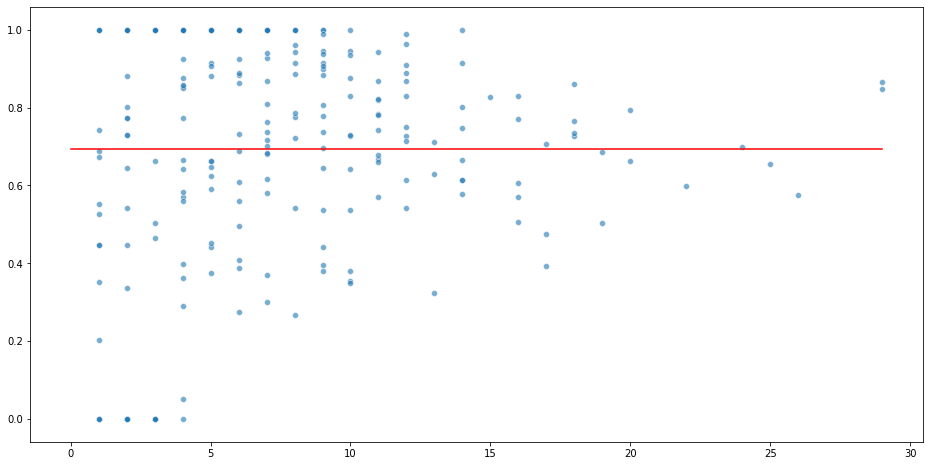

In [736]:
scatter_plot_gsc(ncr_scores['simgic'], ncr_df['NCR_HPO_codes'])

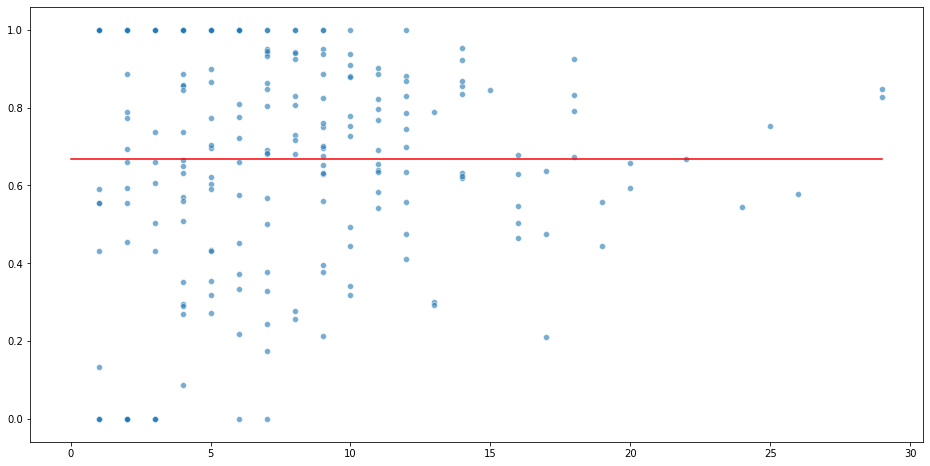

In [737]:
scatter_plot_gsc(clinphen_scores['simgic'], clinphen_df['HPO ID'])

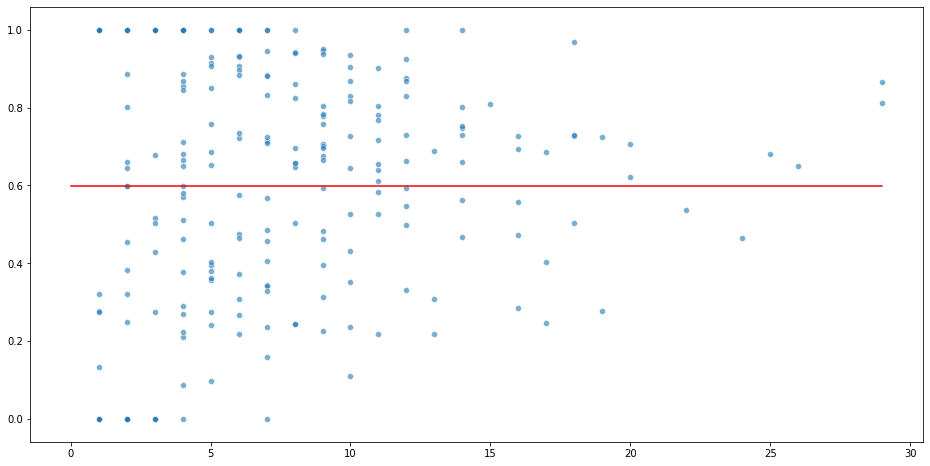

In [738]:
scatter_plot_gsc(biolink_scores['simgic'], biolink_df['Biolink_HPO_codes'])

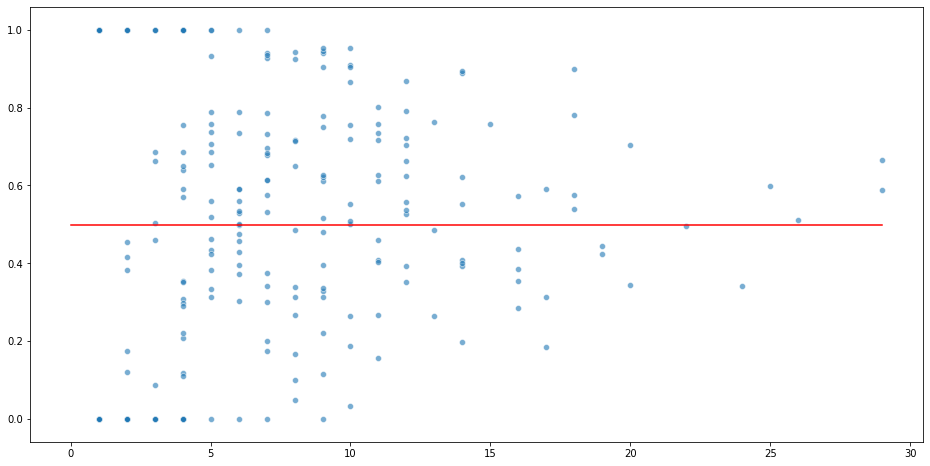

In [739]:
scatter_plot_gsc(ta_for_health_scores['simgic'], ta_health_df['HPO_codes'])

ValueError: `legend` must be 'brief', 'full', or False

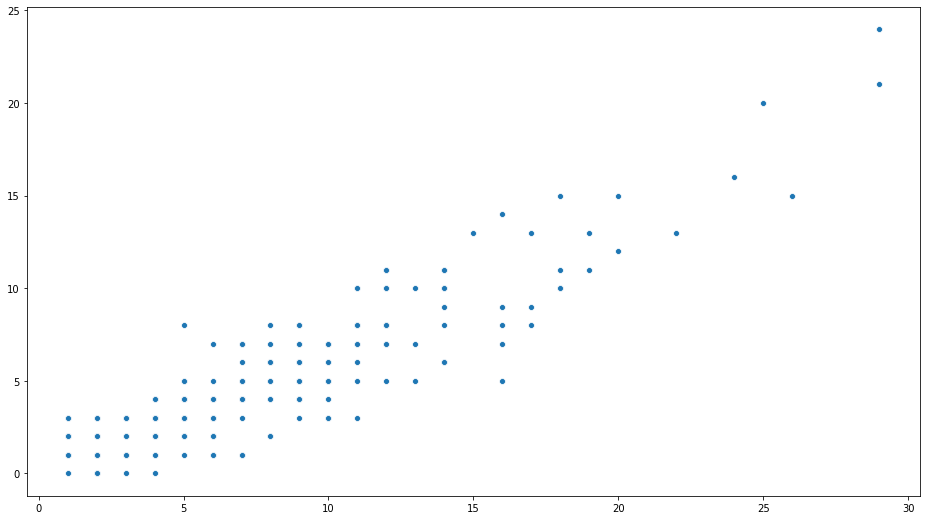

In [747]:
plt.figure(figsize=(16,9))
sns.scatterplot([len(set(l)) for l in gsc_data['HPO_codes']], [len(set(l)) for l in ncr_df['NCR_HPO_codes']])
sns.scatterplot([len(set(l)) for l in gsc_data['HPO_codes']], [len(set(l)) for l in ta_health_df['HPO_codes']])
sns.scatterplot([len(set(l)) for l in gsc_data['HPO_codes']], [len(set(l)) for l in clinphen_df['HPO ID']])
sns.scatterplot([len(set(l)) for l in gsc_data['HPO_codes']], [len(set(l)) for l in biolink_df['Biolink_HPO_codes']])

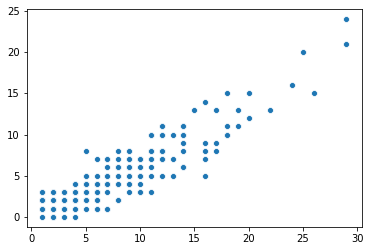

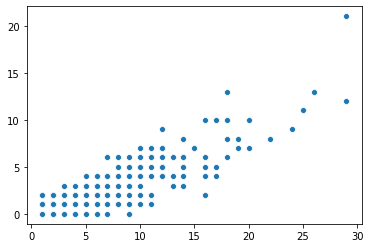

### Weighted average

In [725]:
def weighted_average(scores, hpo_lists, weigh_by_ground_truth_count=True):
    if weigh_by_ground_truth_count:
        x = [len(set(hpo_list)) for hpo_list in gsc_data['HPO_codes']]
    else:
        x = [len(set(hpo_list)) for hpo_list in hpo_lists]
    y = list(scores)
    return np.average(y, weights=x)

In [726]:
weighted_average(ncr_scores['simgic'], ncr_df['NCR_HPO_codes'])

0.7240738685056423

In [727]:
weighted_average(ta_for_health_scores['simgic'], ta_health_df['HPO_codes'])

0.5293408575785705

In [770]:
results_matrix = results_matrix_df[['simgic', 'jaccard_avg']]

In [771]:
results_matrix

,simgic,jaccard_avg
NCR,0.6936,0.3910
TextAnalytics,0.4986,0.3700
ClinPhen,0.6670,0.4080
BioLink,0.5982,0.3900
IHP,0.0473,0.1069


In [776]:
results_matrix['weighted_simgic'] = [
    weighted_average(ncr_scores['simgic'], ncr_df['NCR_HPO_codes']),
    weighted_average(ta_for_health_scores['simgic'], ta_health_df['HPO_codes']),
    weighted_average(clinphen_scores['simgic'], clinphen_df['HPO ID']),
    weighted_average(biolink_scores['simgic'], biolink_df['Biolink_HPO_codes']),
    weighted_average(ihp_scores['simgic'], ihp_df['HPO_codes'])
]

C:\Users\t-mikuzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [780]:
results_matrix['weighted_jaccard'] = [
    weighted_average(ncr_scores['jaccard_avg'], ncr_df['NCR_HPO_codes']),
    weighted_average(ta_for_health_scores['jaccard_avg'], ta_health_df['HPO_codes']),
    weighted_average(clinphen_scores['jaccard_avg'], clinphen_df['HPO ID']),
    weighted_average(biolink_scores['jaccard_avg'], biolink_df['Biolink_HPO_codes']),
    weighted_average(ihp_scores['jaccard_avg'], ihp_df['HPO_codes'])
]

C:\Users\t-mikuzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [781]:
pd.set_option("display.precision", 4)

In [782]:
results_matrix[['simgic', 'weighted_simgic', 'jaccard_avg', 'weighted_jaccard']].style.apply(highlight_max)

,simgic,weighted_simgic,jaccard_avg,weighted_jaccard
NCR,0.6936,0.7241,0.3910,0.3287
TextAnalytics,0.4986,0.5293,0.3700,0.3245
ClinPhen,0.6670,0.6835,0.4080,0.3354
BioLink,0.5982,0.6301,0.3900,0.3287
IHP,0.0473,0.0456,0.1069,0.1041
